In [ ]:
import pandas as pd
import numpy as np
import cassiopeia as cas
import matplotlib as cm
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
from collections import defaultdict
from tqdm.auto import tqdm
import scanpy as sc

In [ ]:
import meta_entropy as meta_entropy

In [ ]:
# load cassiopeia tree object
with open('path/to/tree.pkl', 'rb') as fp:
    tree = pickle.load(fp)

In [ ]:
# get the networkx object 
G = tree._CassiopeiaTree__network.copy()

In [ ]:
root = [n for n in G if G.in_degree(n) == 0][0]

In [ ]:
G = meta_entropy.set_depth(G, root)
max_depth = meta_entropy.get_max_depth(G, root)
G = meta_entropy.set_progeny_size(G, root)

In [ ]:
leaves = [n for n in G if G.out_degree(n) == 0]

In [ ]:
adata = sc.read_h5('/path/to/rna.h5ad')
meta = adata.obs.loc[leaves, ['cell_type']]

In [ ]:
for i in tqdm(meta.columns, desc="Processing each meta item"):
    meta_vals = list(meta[i].unique())
    G = meta_entropy.assign_meta(G, meta[i])

    clone_entropys = {}
    for d in tqdm(range(1, max_depth), desc="Calculating Chisq at each level"):
        num_clades = meta_entropy.sample_chisq_test(G, meta_vals, depth=d)
        clone_entropy, _ = meta_entropy.calc_info_gain(G, meta_vals, depth = d)
        clone_entropys[num_clades] = clone_entropy

In [ ]:
df = {}
flag = 1
for k, v in clone_entropys.items():
    if flag > 4 : break
    df[k] = pd.DataFrame([[str(k) + "_" + k2, v2[0], flag] for k2, v2 in v.items() if k2 not in [0,1]],
                 columns = ['clade', 'entropy', 'depth']).set_index('clade')
    flag=flag+1
tmp = pd.concat(df)

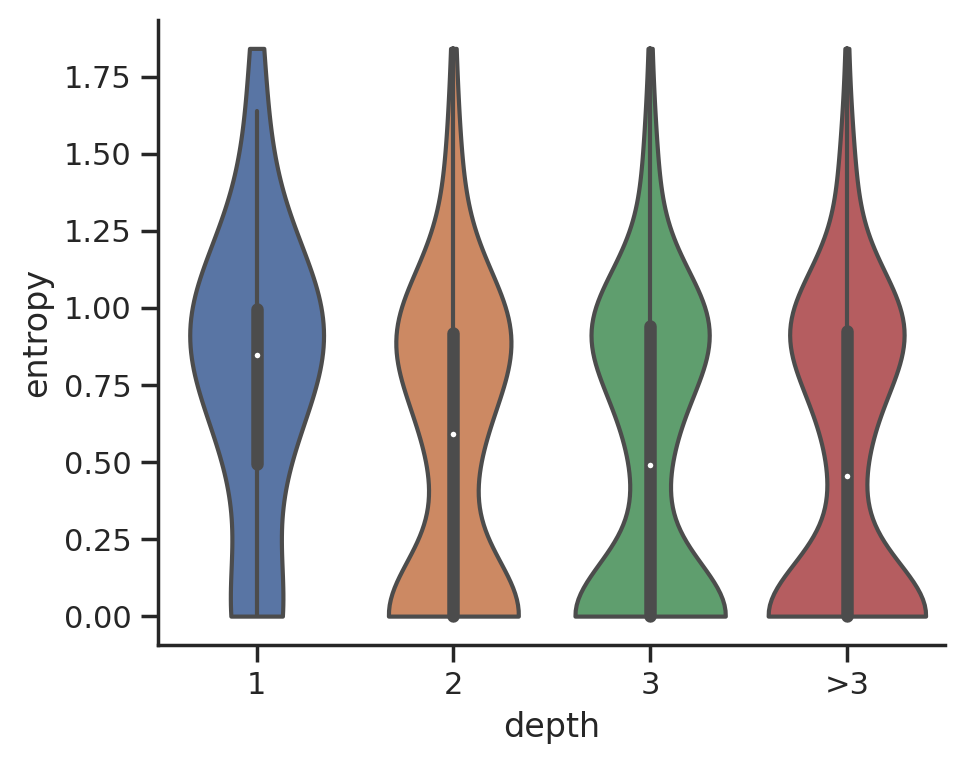

In [ ]:
fig, ax = plt.subplots(figsize=(5,4))
ax = sns.violinplot(tmp, x='depth', y='entropy', size=3, cut = 0);
ax.set_xticklabels(['1','2','3', '>3'])
plt.tight_layout()
plt.show()